In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycytominer import aggregate, normalize
from cytominer_eval import evaluate
from cytominer_eval.transform import metric_melt
from sklearn.decomposition import PCA
import sys
sys.path.insert(0, "/Users/mbornhol/git/neural-profiling")
from utils import eval

In [13]:
df = pd.read_csv('811_aggregated_median.csv')
df.shape

/Users/mbornhol/miniconda3/envs/cyto_eval/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(8745, 1298)

In [ ]:
e = eval.evaluation(df_path= '811_aggregated_median.csv')
con = e.norm_agg()

In [3]:
enr = e.eval(con, operation = 'enrichment')
prec = e.eval(con, operation = 'precision_recall')
hit_ls = e.eval(con, operation = 'hit@k')

running hit@k


In [4]:
bins = np.arange(0,200,5)
h, bins = np.histogram(hit_ls[0], bins=bins)
hit = pd.DataFrame()
hit['bins'] = bins[:-1]
hit['h'] = h

In [5]:
res = pd.concat([enr, prec, hit], ignore_index=False, axis=1)
res.to_csv('811_results.csv', index=False)

In [ ]:
res = e.eval(con)
plt.style.use({'figure.facecolor':'white'})
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(12,8))
plt.title("Average precision @k, top 20 MOAs")
plt.plot(res_pre_baseline["k"], res_pre_baseline["precision"], marker="o", color="green", label = 'cytominer baseline')
plt.plot(res_prec_spherized['k'], res_prec_spherized["precision"], marker="o", color="blue", label = 'efficientnet spherized')
plt.plot(res_prec_mad_dmso['k'], res_prec_mad_dmso["precision"], marker="o", color="yellow", label = 'efficientnet mad robustized')
plt.ylabel('precision')
plt.xlabel('k')
plt.legend(loc = 'upper right', shadow=True)
plt.show()

In [ ]:
res = e.eval(con, operation = 'precision_recall')
res

In [ ]:
res = e.eval(con, operation = 'hit@k')
len(res[0])

The old way:

In [14]:
df = pd.read_csv('811_aggregated_median.csv')

df_meta = pd.read_csv('/Users/mbornhol/git/neural-profiling/pre-trained/data-prep/02_index_preperation/repurposing_info_external_moa_map_resolved.tsv', sep='\t')
df_meta = df_meta[['broad_sample', 'moa']]
df_meta.rename(columns = {'broad_sample' : 'Metadata_broad_sample', 'moa' : 'Metadata_moa'}, inplace=True)

/Users/mbornhol/miniconda3/envs/cyto_eval/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
features = [f for f in df.columns if f.startswith('eff')]
meta_features = [feat for feat in df.columns if feat not in features]
top_moa = df.Metadata_moa.value_counts()[1:20].keys().tolist()

In [16]:
k_range = [5, 10, 15, 20, 25]
p_range = np.arange(0.995, 0.96, -0.005)

In [17]:
sphere = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='spherize',
    output_file='none'
)

In [24]:
con = aggregate(
    sphere,
    strata=["Metadata_broad_sample"],
    features=features
)

In [25]:
con = pd.merge(con, df_meta, how='left', on=['Metadata_broad_sample'])

In [21]:
res_sphere = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="precision_recall",
        similarity_metric="pearson",
        enrichment_percentile=p_range
    )
res_sphere

AssertionError: Metadata feature not found

In [26]:
con = con[con["Metadata_broad_sample"] != 'DMSO']
features = [f for f in df.columns if f.startswith('eff')]
prc = evaluate(
    profiles=con,
    features=features,
    meta_features=['Metadata_broad_sample', "Metadata_moa"],
    replicate_groups=["Metadata_moa"],
    operation="precision_recall",
    similarity_metric="pearson",
    precision_recall_k=k_range
)

In [27]:
top_moa = df.Metadata_moa.value_counts()[1:20].keys().tolist()
top_prc = prc[prc['Metadata_moa'].isin(top_moa)].reset_index(drop=True)
pr_av = []
for k in top_prc.k.unique():
    pr_av.append(top_prc.query("k==@k").mean().tolist())
res_prec_select_sphere = pd.DataFrame(pr_av, columns=["k","precision","recall"])
res_prec_select_sphere

,k,precision,recall
0,5.0,0.147368,0.003581
1,10.0,0.126316,0.006337
2,15.0,0.115789,0.008396
3,20.0,0.107895,0.010263
4,25.0,0.094737,0.011037


In [29]:
pr_av = []
for k in prc.k.unique():
    pr_av.append(prc.query("k==@k").mean().tolist())
res_prec_select_sphere = pd.DataFrame(pr_av, columns=["k","precision","recall"])
res_prec_select_sphere

,k,precision,recall
0,5.0,0.043590,0.016130
1,10.0,0.039744,0.029995
2,15.0,0.039031,0.038416
3,20.0,0.034615,0.041650
4,25.0,0.030598,0.042675


In [103]:
meta_features = [feat for feat in con.columns if feat not in features]
melt = metric_melt(con, features, meta_features, eval_metric='precision_recall').sort_values(
        by="similarity_metric", ascending=False)
grouped = melt.groupby(['Metadata_broad_sample_pair_a'])

In [104]:
def index_hits(df):
    df.reset_index(drop = True, inplace=True)
    df['rank'] = range(len(df))
    moa = df.Metadata_moa_pair_a.iloc[0]
    df['same_moa'] = df['Metadata_moa_pair_b'] == moa
    df.drop(columns=['pair_a_index', 'pair_b_index', 'similarity_metric'], inplace=True)
    df = df[['Metadata_broad_sample_pair_a', 'Metadata_moa_pair_a','Metadata_broad_sample_pair_b', 'Metadata_moa_pair_b', 'rank','same_moa']]
    return df

In [105]:
indexes = grouped.apply(lambda x: index_hits(x))
indexes.reset_index(drop=True, inplace=True)
indexes.rename(columns={'Metadata_broad_sample_pair_a': 'target_compound', 'Metadata_broad_sample_pair_b':'match_compound', 'Metadata_moa_pair_a':'target_moa', 'Metadata_moa_pair_b':'match_moa'}, inplace=True)

def calc_hits(df, only_first = False):
    group = df.groupby(['target_compound'])
    index_ls = group.apply(lambda x: find_hits(x, only_first = only_first))
    return index_ls

def find_hits(df, only_first):
    #print(df.target_compound.iloc[0])
    index_ls = df[df['same_moa'] == True]['rank'].tolist()
    if len(index_ls) == 0:
            print(df.target_compound.iloc[0])
    if only_first:
        return index_ls[0]
    else:
        return index_ls

In [106]:
index_series = calc_hits(indexes)
index_flat = [item for sublist in index_series.tolist() for item in sublist]

In [108]:
#random
con_copy = con.copy()
con_copy[features] = con_copy[features].iloc[np.random.permutation(len(con))].reset_index(drop=True)
ran_melt = metric_melt(con_copy, features, meta_features, eval_metric='precision_recall').sort_values(
        by="similarity_metric", ascending=False)
ran_grouped = ran_melt.groupby(['Metadata_broad_sample_pair_a'])
ran_indexes = ran_grouped.apply(lambda x: index_hits(x))
ran_indexes.reset_index(drop=True, inplace=True)
ran_indexes.rename(columns={'Metadata_broad_sample_pair_a': 'target_compound', 'Metadata_broad_sample_pair_b':'match_compound', 'Metadata_moa_pair_a':'target_moa', 'Metadata_moa_pair_b':'match_moa'}, inplace=True)

In [109]:
ran_index_series = calc_hits(ran_indexes)
ran_index_flat = [item for sublist in ran_index_series.tolist() for item in sublist]


In [110]:
%matplotlib qt
bins = np.arange(0,200,5)
plt.style.use({'figure.facecolor':'white'})
plt.hist(index_flat, bins, alpha=0.6, color='blue', label='CP features')
plt.hist(ran_index_flat, bins,alpha=0.4, color='red', label='randomized')
plt.xlabel('hit @ k')
plt.ylabel('Count')
plt.title('Histogram of all hits')
plt.legend()
plt.show()

In [ ]:
def pca_plot(df):
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(df[features].values)
    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1]
    df['pca-three'] = pca_result[:,2]
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    plt.style.use({'figure.facecolor':'white'})
    plt.scatter(df['pca-one'], df['pca-two'], s = 3, alpha= 0.4)
    plt.show()
pca_plot(df)

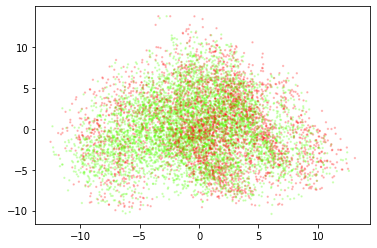

In [24]:
def is_dmso(sample):
    if sample == 'DMSO':
        return 0
    else:
        return 1
df = df.sample(frac=1).reset_index(drop=True)
df['color'] = df.Metadata_broad_sample.apply(is_dmso)
plt.style.use({'figure.facecolor':'white'})
plt.scatter(df['pca-one'], df['pca-two'], c = df['color'], marker= 'o', s = 2, alpha= 0.2, cmap = 'prism')
plt.show()


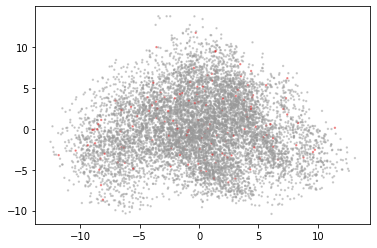

In [38]:
def wells(well):
    if well.startswith('B04'):
        return 0
    else:
        return 1
df['color'] = df.Metadata_Well.apply(wells)
plt.style.use({'figure.facecolor':'white'})
plt.scatter(df['pca-one'], df['pca-two'], c = df['color'], marker= 'o', s = 2, alpha= 0.4, cmap = 'Set1') #  cmap = 'prism'
plt.show()

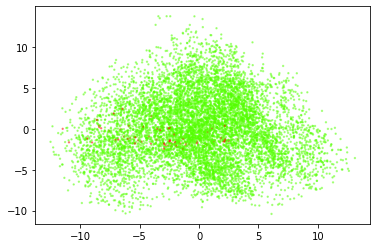

In [54]:
def plate_map(plate):
    if plate.endswith('15221'):
        return 0
    else:
        return 1

df['color'] = df.Metadata_Plate.apply(plate_map)
plt.style.use({'figure.facecolor':'white'})
plt.scatter(df['pca-one'], df['pca-two'], c = df['color'], marker= 'o', s = 2, alpha= 0.4, cmap = 'prism')
plt.show()

Explained variation per principal component: [0.07363548 0.05444171 0.02998903]


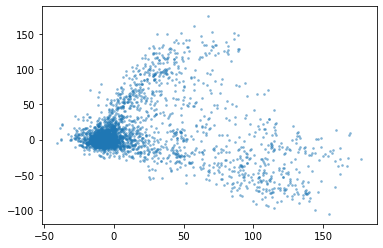

In [59]:
pca_plot(sphere)

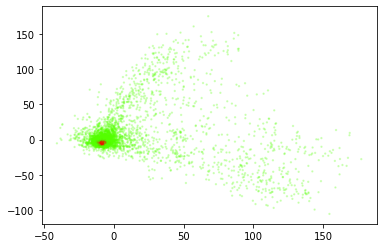

In [60]:
sphere = sphere.sample(frac=1).reset_index(drop=True)
sphere['color'] = sphere.Metadata_broad_sample.apply(is_dmso)
plt.style.use({'figure.facecolor':'white'})
plt.scatter(sphere['pca-one'], sphere['pca-two'], c = sphere['color'], marker= 'o', s = 2, alpha= 0.2, cmap = 'prism')
plt.show()


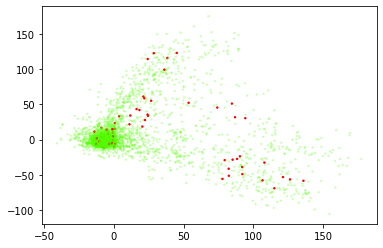

In [86]:
def wells(well):
    if well.startswith('I01'):
        return 0
    else:
        return 0.8
sphere['color'] = sphere.Metadata_Well.apply(wells)
plt.style.use({'figure.facecolor':'white'})
plt.scatter(sphere['pca-one'], sphere['pca-two'], c = sphere['color'], marker= 'o', s = 2, alpha= 1- sphere['color'], cmap = 'prism') #  cmap = 'prism'
plt.show()

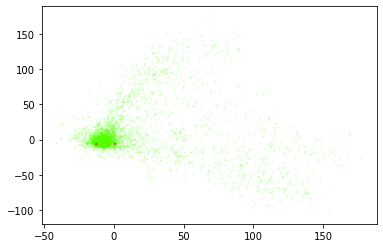

In [82]:
def sample(sample):
    if sample == 'BRD-K64622987-001-01-4':
        return 0
    else:
        return 0.9
sphere['color'] = sphere.Metadata_broad_sample.apply(sample)
plt.style.use({'figure.facecolor':'white'})
plt.scatter(sphere['pca-one'], sphere['pca-two'], c = sphere['color'], marker= 'o', s = 2, alpha= 1- sphere['color'], cmap = 'prism') #  cmap = 'prism'
plt.show()

In [87]:
df[df.Metadata_broad_sample == 'BRD-K64622987-001-01-4'].Metadata_Plate

3       SQ00015202
2305    SQ00015148
2699    SQ00015149
6985    SQ00015146
Name: Metadata_Plate, dtype: object

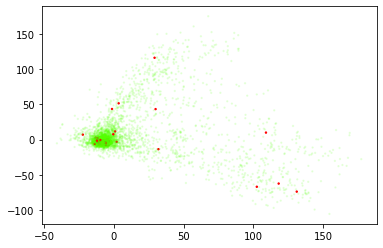

In [92]:
def plate_map(plate):
    if plate == 'SQ00015146':
        return 0
    else:
        return 0.9

sphere['color'] = sphere.Metadata_Plate.apply(plate_map)
plt.style.use({'figure.facecolor':'white'})
plt.scatter(sphere['pca-one'], sphere['pca-two'], c = sphere['color'], marker= 'o', s = 2, alpha= 1- sphere['color'], cmap = 'prism')
plt.show()
